<a href="https://colab.research.google.com/github/chaiwencw/Higher-Education-Students-Performance-Evaluation/blob/main/Student_Grade_Prediction_Using_ML_Model(Asgn2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necessaries libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, chi2

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report


# **1.0 Data Preprocessing**


In [ ]:
#import dataset
url = 'https://raw.githubusercontent.com/chaiwencw/EDA-Higher-Education-Students-Performance-Evaluation/main/student_prediction_edited.csv'
df = pd.read_csv(url)
df.head(3)

,STUDENTID,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,LIVING,MOTHER_EDU,FATHER_EDU,#_SIBLINGS,KIDS,MOTHER_JOB,FATHER_JOB,STUDY_HRS,CUML_GPA,EXP_GPA
0,STUDENT1,23,2,3,3,1,2,2,170,1,1,1,2,3,1,2,5,7.0,1,1
1,STUDENT2,23,2,3,3,1,2,2,185,1,1,2,3,2,1,2,1,4.0,2,3
2,STUDENT3,24,2,2,3,2,2,2,255,4,2,2,2,2,1,2,1,2.0,2,2


In [ ]:
#rename columns
df.rename(columns ={'LIVING':'ACCOMM_TYPE','KIDS':'PARENTAL_STATUS'}, inplace = True)
#drop STUDENTID column
df = df.drop('STUDENTID', axis=1)

* Handling with Missing Values

In [ ]:
# Count null values in each column
df.isnull().sum()

AGE                 0
GENDER              0
HS_TYPE             0
SCHOLARSHIP         0
WORK                0
ACTIVITY            0
PARTNER             0
SALARY              0
TRANSPORT           0
ACCOMM_TYPE         0
MOTHER_EDU          0
FATHER_EDU          0
#_SIBLINGS          0
PARENTAL_STATUS     0
MOTHER_JOB          0
FATHER_JOB          0
STUDY_HRS          29
CUML_GPA            0
EXP_GPA             0
dtype: int64

The STUDY_HRS column has 29 missing values. The most common method used for data imputation is replacing them with their mean or median.Since the mean value will be highly influenced by outliers, we use the median.

In [ ]:
# Fill the null values with the median
df.fillna({'STUDY_HRS': df.STUDY_HRS.median()}, inplace = True)
print(f'Number of missing values in STUDY_HRS after median imputation: {df.STUDY_HRS.isnull().sum()}.')

Number of missing values in STUDY_HRS after median imputation: 0.


In [ ]:
# Extract independent variables
features = df.drop('EXP_GPA',axis=1) 
# Extract dependent variable
target = df['EXP_GPA'] 

In [ ]:
features.shape

(145, 18)

We have 145 samples and 18 variables in the dataset.

# **2.0 Feature Scaling**

  * Rescaling is a common preprocessing task in machine learning. Many machine learning algorithms will assume all features are on the same scale. 
  * The categorical columns in the given dataset are already encoded. So, no scaling for them.
  *  For numerical columns (AGE, SALARY, STUDY_HRS), we choose to rescaling the features to be approximately standard normally distributed with mean 0 and standard deviation 1 (Standardizing)

In [ ]:
# Create scaler
sc = preprocessing.StandardScaler()
# Transform the feature
standardized = sc.fit_transform(df[{'STUDY_HRS','SALARY','AGE'}])
# Show feature
standardized

array([[-0.59497941,  0.46699912,  0.42682079],
       [-0.3918271 ,  0.46699912, -0.3099532 ],
       [ 0.55621702,  0.9919206 , -0.80113586],
       [ 0.01447752, -1.10776534,  0.18122946],
       [ 1.43654369,  0.46699912, -0.55554453],
       [ 0.62393445,  0.46699912, -0.3099532 ],
       [-0.79813172, -1.10776534, -1.04672719],
       [ 0.48849958, -1.63268683, -0.3099532 ],
       [-0.93356659,  0.9919206 , -0.3099532 ],
       [ 1.43654369,  0.46699912, -0.80113586],
       [ 1.03023907, -1.63268683, -0.3099532 ],
       [ 2.24915293, -0.58284386,  0.91800346],
       [-0.73041428, -0.58284386,  0.42682079],
       [-0.32410966,  0.46699912, -0.3099532 ],
       [ 1.639696  ,  2.04176357, -1.04672719],
       [-0.86584916,  0.46699912, -0.80113586],
       [-0.73041428, -1.10776534, -0.55554453],
       [-0.32410966,  0.9919206 , -0.06436187],
       [ 0.96252164, -0.58284386,  3.86509942],
       [ 0.28534727, -0.58284386,  2.14596011],
       [-0.32410966, -1.10776534,  1.409

In [ ]:
print("Mean:", round(standardized.mean()))
print("Standard deviation:", standardized.std())

Mean: 0
Standard deviation: 1.0


After scaling, the numerical columns has the mean of 0 and the standard deviation of 1.

# **3.0 Feature Selection**

Filter Methods:

1. Correlation Coefficient
  - Correlation Among Features
  
    - Here we check for correlation between features (or pairwise correlation). This allows us to detect highly correlated features which bring no new info to the dataset. So, these features will be dropped to avoid model complexity and the chance of overfitting. 
    - There are few methods of correlation include pearson(standard correlation coefficient), kendall(Kendall Tau correlation coefficient),
spearman(pearman rank correlation), etc. The defaut setting is 'pearson'.

In [ ]:
#obtain correlation matrix
corr_mat = features.corr().abs()

Note that correlation matrix is just the mirror reflection about the diagonal and all the diagonal elements will be 1. Here we select the upper triangular.

In [ ]:
#obtain upper triangle of the correlation matrix (no diagonal)
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))
#drop the columns (features) with the correlation coefficient > 0.6
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.6)]
if len(to_drop) == 0:
  print('No highly correlated features are found!')
else:
  print(to_drop)

No highly correlated features are found!


Since no features are highly correlated, no dropping is performed. We can visualize the features correlation by plotting heatmap.

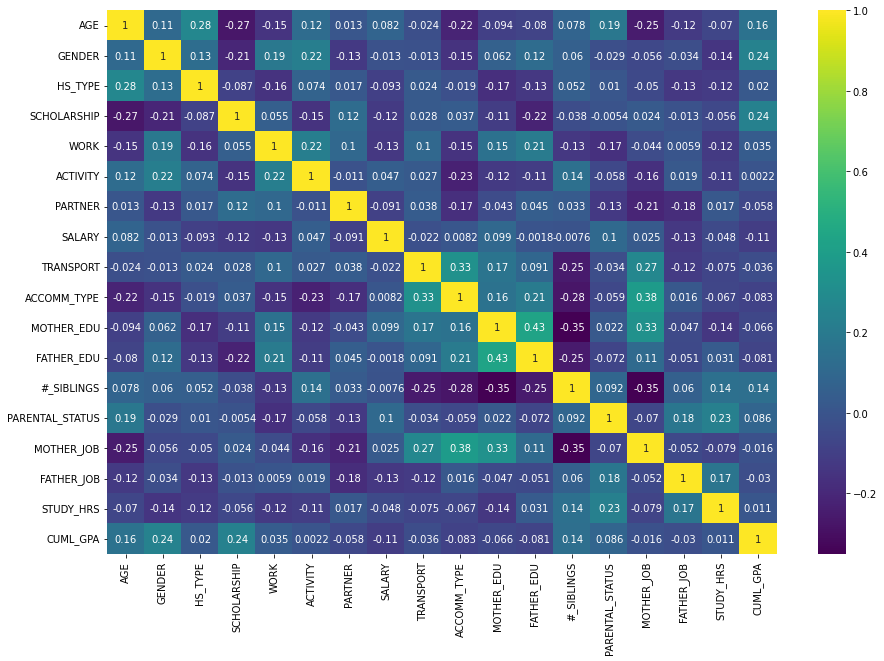

In [ ]:
corr_features = corr_mat.index
plt.figure(figsize=(15,10))
#plot heat map
g=sns.heatmap(df[corr_features].corr(),annot=True,cmap="viridis")

Consider high correlation if the correlation coefficient > 0.6. From the heatmap, we can see that no features are highly correlated. Among all, the highest value is 0.43, which indicates FATHER_EDU and MOTHER_EDU are moderately correlated.



  - Correlation between Features and Target
    * Assume that good variables are highly correlated with the target.



In [ ]:
#Correlation between features and target
corr = df.corr()["EXP_GPA"].sort_values(ascending=False)[1:]
# Absolute for positive values
abs_corr = abs(corr)
# Threshold for features to keep
new_features = abs_corr[abs_corr > 0.6]
new_features

CUML_GPA    0.657853
Name: EXP_GPA, dtype: float64

In [ ]:
#Visualization by ploting heatmap
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(df.corr()[['EXP_GPA']].sort_values(by='EXP_GPA', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the Expected GPA During Graduation')

From the above, we know that CUML_GPA is the only feature that is highly correlated with EXP_GPA as the correlation value is greater than 0.6. 

2. Univariate Statistics

  * Univariate feature selection works by selecting the best features 
based on univariate statistical tests. Here we use `SelectKBest` to obtain the highest scoring feature and remove the rest.
  * The two commonly used score functions are `chi2` (Chi-Square) and `f_classif` (ANOVA F-value).
  * Note that Chi-Square is for categorical features only.

Feature 0 (GENDER): 2.551714840379639
Feature 1 (HS_TYPE): 0.34674345547335356
Feature 2 (SCHOLARSHIP): 2.499809732850068
Feature 3 (WORK): 0.05154657398888035
Feature 4 (ACTIVITY): 0.4500017975266034
Feature 5 (PARTNER): 0.2024372890849788
Feature 6 (TRANSPORT): 2.132128149113626
Feature 7 (ACCOMM_TYPE): 0.717614228160695
Feature 8 (MOTHER_EDU): 1.6711400098358924
Feature 9 (FATHER_EDU): 3.32849436348359
Feature 10 (#_SIBLINGS): 2.1722179323020554
Feature 11 (PARENTAL_STATUS): 1.4158482633778293
Feature 12 (MOTHER_JOB): 0.195324917124562
Feature 13 (FATHER_JOB): 1.1795304206865918
Feature 14 (CUML_GPA): 34.33647618757385

Visualizing:



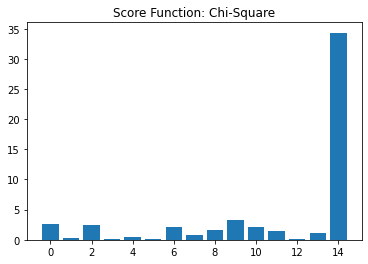

In [ ]:
#categorical features
cat_features = features.drop({'STUDY_HRS','AGE','SALARY'},axis=1)
# define feature selection
kbest = SelectKBest(score_func=chi2, k ='all')
# apply feature selection
kbest = kbest.fit(cat_features, target)
# what are scores for the features
for i in range(len(kbest.scores_)):
	print(f'Feature {i} ({cat_features.columns[i]}): {kbest.scores_[i]}')
new_features = kbest.transform(cat_features)
print('\nVisualizing:\n')
#  plot the scores
plt.bar([i for i in range(len(kbest.scores_))], kbest.scores_)
plt.title('Score Function: Chi-Square')
plt.show()

In [ ]:
#Numerical features
num_features = features[{'STUDY_HRS','AGE','SALARY'}]
# define feature selection
kbest = SelectKBest(score_func=f_classif,k='all')
# apply feature selection
kbest = kbest.fit(num_features, target)
# find the scores for features
for i in range(len(kbest.scores_)):
	print(f'Feature {i} ({num_features.columns[i]}): {kbest.scores_[i]}')
new_features = kbest.transform(num_features)

Feature 0 (SALARY): 1.39798651443096
Feature 1 (AGE): 0.7274790741305651
Feature 2 (STUDY_HRS): 1.389484699001954


In univariate statistics approach, CUML_GPA obtains the highest scores.


Overall, by using filter methods(correlation coefficient and univariate statistics), CUML_GPA is the only selected feature as it is highly correlated with the target (EXP_GPA) and also the highest scoring feature in SelectKBest. Therefore, the new dataset for machine learning model building in predicting student’s CGPA at graduation only consists of one feature, that is CUML_GPA.

In [ ]:
newdf = df[{'CUML_GPA','EXP_GPA'}]
newdf.head()

,CUML_GPA,EXP_GPA
0,1,1
1,2,3
2,2,2
3,3,2
4,2,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


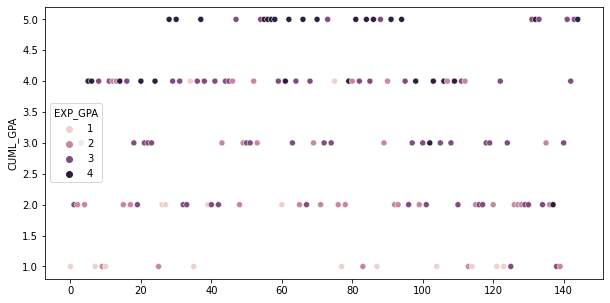

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(newdf.index,newdf['CUML_GPA'],hue=newdf['EXP_GPA'])
plt.show()

In [ ]:
# Split the dataset into training set and test set.
X_train, X_test, y_train, y_test = train_test_split(
    newdf.drop('EXP_GPA',axis=1), newdf['EXP_GPA'], test_size = 0.30,random_state= 1)

In [ ]:
#shape of the training set and test set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((101, 1), (44, 1), (101,), (44,))

# **4.0 Support Vector Machine**

Model performance evaluation metrics:
1. Accuracy score
2. Confusion matrix 
3. Classification report
    * Precision: Ratio of TP predictions relative to total positive predictions (TP+FP).
    * Recall: Ratio of TP predictions relative to total actual positives (TP+FN).
    * F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the expected model performance.

## **4.1 Linear SVM**

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, predictions)), end = '\n\n')
print('Confusion Matrix: \n\n' + str(confusion_matrix(y_test, predictions)), end='\n\n')
print('Classification Report: \n\n' + str(classification_report(y_test, predictions)))

Accuracy score: 0.4772727272727273

Confusion Matrix: 

[[ 0  4  0  0]
 [ 0  6  4  0]
 [ 0  7 10  3]
 [ 0  0  5  5]]

Classification Report: 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.35      0.60      0.44        10
           3       0.53      0.50      0.51        20
           4       0.62      0.50      0.56        10

    accuracy                           0.48        44
   macro avg       0.38      0.40      0.38        44
weighted avg       0.46      0.48      0.46        44



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the evaluation metrics above, the linear svm model has low prediction accuracy. Based on the classification report, the precision value of class 1 is 0.

## **4.2 Non-Linear SVM**

* Kernels: Radial Basis Function (RBF), Sigmoid, 
Polynomial

### Approach I: Use `GridSearchCV `to train models with different kernels

In [ ]:
# Grid searching key hyperparametres for SVC
#Create a dictionary and fill out some parameters for kernels, C and gamma
param_grid= {'C': [0.1,1, 10, 100], 'gamma': ['scale'],'kernel': ['poly','rbf', 'sigmoid']}
grid_search = GridSearchCV(model, param_grid, refit=True,verbose=3)
grid_search.fit(X_train, y_train)
# print best parameter after tuning
print(grid_search.best_params_)
 # print how our model looks after hyper-parameter tuning
print(grid_search.best_estimator_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.476 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.550 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.450 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.400 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.300 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.381 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.400 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.400 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.450 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.400 total time=   0.0s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;

In [ ]:
predictions = grid_search.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, predictions)), end = '\n\n')
print('Confusion Matrix: \n\n' + str(confusion_matrix(y_test, predictions)), end='\n\n')
print('Classification Report: \n\n' + str(classification_report(y_test, predictions)))

Accuracy score: 0.5454545454545454

Confusion Matrix: 

[[ 3  1  0  0]
 [ 0  6  4  0]
 [ 1  6 10  3]
 [ 0  0  5  5]]

Classification Report: 

              precision    recall  f1-score   support

           1       0.75      0.75      0.75         4
           2       0.46      0.60      0.52        10
           3       0.53      0.50      0.51        20
           4       0.62      0.50      0.56        10

    accuracy                           0.55        44
   macro avg       0.59      0.59      0.59        44
weighted avg       0.55      0.55      0.55        44



From the evaluation metrics above, changing linear kernel to RBF kernel improve the prediction accuracy. Based on the classification report, class 1 has the highest precision (0.75), followed by class 4 (0.62), class 3(0.52) and class 2 (0.46). The values of precision and recall for class 1 are the same. This indicates that, for class 1, the model is equally good at assigning positive classifications correctly as it is at classifying positive instances correctly.

### Approach II: Use `for` loop to train models with different kernels


In [ ]:
poly_params = {'kernel':'poly', 'degree':3}
rbf_params = {'kernel':'rbf'}
sigmoid_params = {'kernel':'sigmoid'}
params_list = [poly_params, rbf_params, sigmoid_params]
for params in params_list:
    
    classifier = SVC(**params, gamma='auto')
    classifier.fit(X_train, y_train)
    
    predictions = classifier.predict(X_test)
    
    print("Kernel: " + params['kernel'])
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("Accuracy:")
    print(accuracy_score(y_test, predictions))
    print("")

Kernel: poly
Confusion Matrix:
[[ 0  4  0  0]
 [ 0  9  1  0]
 [ 0 11  6  3]
 [ 0  0  5  5]]
Accuracy:
0.45454545454545453

Kernel: rbf
Confusion Matrix:
[[ 3  1  0  0]
 [ 0  6  4  0]
 [ 1  6 10  3]
 [ 0  0  5  5]]
Accuracy:
0.5454545454545454

Kernel: sigmoid
Confusion Matrix:
[[ 0  0  4  0]
 [ 0  0 10  0]
 [ 0  0 20  0]
 [ 0  0 10  0]]
Accuracy:
0.45454545454545453



In Approach 2, we can clearly see the accuracy score of different kernels. The radial basis function outperforms the other kernels.

# **5.0 K-Nearest Neighbor (KNN)**

In [ ]:
knn = KNN()
knn.fit(X_train,y_train)
preds = knn.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, preds)), end = '\n\n')
print('Confusion Matrix: \n\n' + str(confusion_matrix(y_test, preds)), end='\n\n')
print('Classification Report: \n\n' + str(classification_report(y_test, preds)))

Accuracy score: 0.3181818181818182

Confusion Matrix: 

[[ 0  4  0  0]
 [ 0  7  3  0]
 [ 0 13  7  0]
 [ 0  5  5  0]]

Classification Report: 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.24      0.70      0.36        10
           3       0.47      0.35      0.40        20
           4       0.00      0.00      0.00        10

    accuracy                           0.32        44
   macro avg       0.18      0.26      0.19        44
weighted avg       0.27      0.32      0.26        44



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the above, the accuracy score of KNN model is very low (about 32%). The precision values of every class are low. To improve the result, parameter tuning can be applied. In KNN, the parameter to be tuned is n_neighbors 

In [ ]:
#define parameter dictionary
param_grid = {'n_neighbors':np.arange(1,20)}
#apply grid search with cross validation
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)
#print the best score
knn_cv.best_score_

0.5638095238095239

The accuracy score is improved from 0.32 to 0.56 after parameter tuning.


# **6.0 Logistic Regression**

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
print('Accuracy score: ' + str(accuracy_score(y_test, predictions)),end = '\n\n')
print('Confusion Matrix: \n\n' + str(confusion_matrix(y_test, predictions)), end = '\n\n')
print('Classification Report: \n\n' + str(classification_report(y_test,predictions)))

Accuracy score: 0.4772727272727273

Confusion Matrix: 

[[ 0  4  0  0]
 [ 0  6  4  0]
 [ 0  7 10  3]
 [ 0  0  5  5]]

Classification Report: 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.35      0.60      0.44        10
           3       0.53      0.50      0.51        20
           4       0.62      0.50      0.56        10

    accuracy                           0.48        44
   macro avg       0.38      0.40      0.38        44
weighted avg       0.46      0.48      0.46        44



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall, the accuracy scores of three classification models are considered low as they are less than 60%. One possible reason affecting the result is the class imbalanced in the data. To have more precise result, the sample size has to be increased. 

# References
1. https://www.researchgate.net/publication/332864818_STUDENT_ACADEMIC_PERFORMANCE_PREDICTION_USING_SUPPORT_VECTOR_MACHINE
2. https://medium.com/analytics-vidhya/feature-selection-techniques-2614b3b7efcd
3. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
4. https://github.com/CertifaiAI/data-science-fundamentals